### Прогнозирование уровня средней заработной платы в России

Review criterialess 
Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда.
2. Стабилизация дисперсии (при необходимости).
3. Выбор порядка дифференцирования.
4. Выбор начальных приближений для p, q, P, Q.
5. Обучение и сравнение моделей-кандидатов, выбор победителя.
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.
7. Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as st

#### Загружаем данные из предоставленного файла

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [2]:
data = pd.read_csv('week_1_task_1_WAG_C_M.csv', sep = ';')
data.head()

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6
3,01.04.1993,30.6
4,01.05.1993,37.5


Проведем экспресс анализ загруженных данных

In [3]:
data.shape

(284, 2)

In [4]:
data.dtypes

month       object
WAG_C_M    float64
dtype: object

Переменная month читается как строка. Преобразуем ее к типу datetime.

In [5]:
data['month'] = pd.to_datetime(data['month'], format = '%d.%m.%Y')

In [6]:
data.head()

,month,WAG_C_M
0,1993-01-01,15.3
1,1993-02-01,19.1
2,1993-03-01,23.6
3,1993-04-01,30.6
4,1993-05-01,37.5


### 1.Визуальный анализ

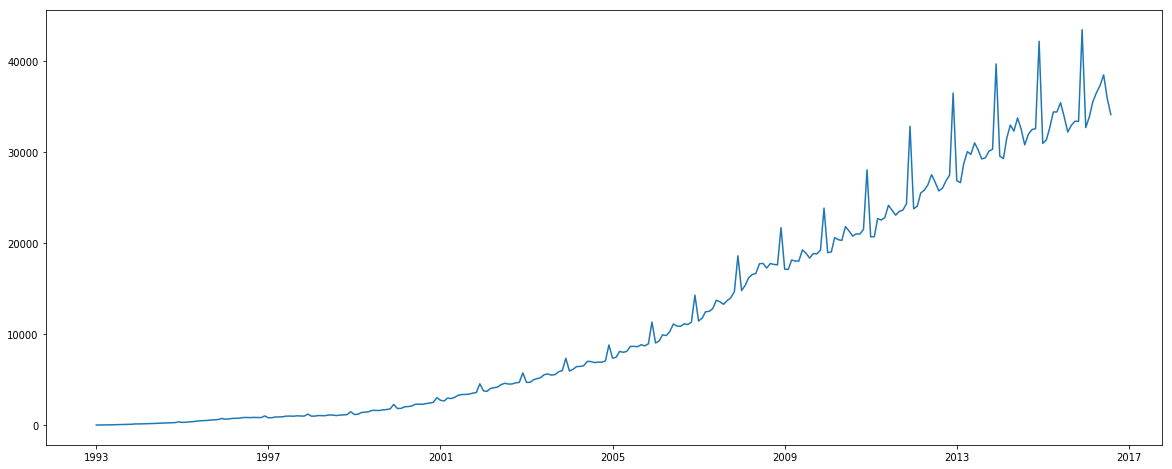

In [7]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
ax.plot(data['month'], data['WAG_C_M'])

plt.show()

Проведем STL декомпозицию ряда и посчитаем критерий Дики-Фуллера.

In [8]:
data.index = data.month

Критерий Дики-Фуллера: p=0.991850


<Figure size 1440x576 with 0 Axes>

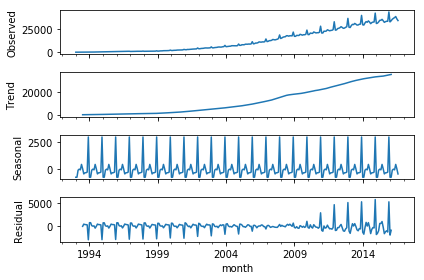

In [9]:
plt.figure(figsize = (20, 8))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

plt.show()

#### Выводы:
a) Временной ряд имеет тренд. <br>
b) Тренд на всем участке кусочно-линейный с "переломом" в конце 90-х. <br>
c) На графике можно заметить периодические всплески и резкие спады за ними, вероятно, связанные с выплатой бонусов в конце года. <br>
d) Амплитуда периодических всплесков со временем увеличивается. <br>
e) Критерий Дики-Фуллера не позволяет нам отвергнуть гипотезу о нестационарности ряда. <br>

Из вышеперечисленного следует, что временной ряд не является стационарным. И для приведения его к стационарному виду потребуется как преобразование Бокса-Кокса, так и дифференцирование.

### 2.Стабилизация дисперсии

In [10]:
from scipy import stats

In [11]:
data['value_bc'] = stats.boxcox(data['WAG_C_M'], lmbda = 0.1)

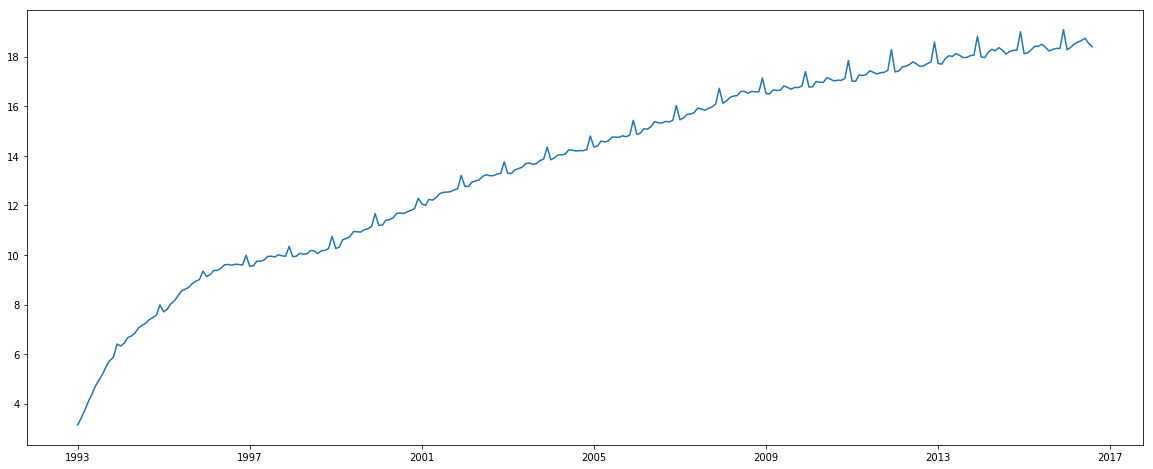

In [12]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
ax.plot(data['month'], data['value_bc'])

plt.show()

При $\lambda$ = 0.1 более или менее получилось сделать амплитуду всплесков одинаковой. 

Будем считать, что нам удалось стабилизировать дисперсию.

Взглянем на критерий Дики-Фуллера

### 3.Выбор порядка дифференцирование

Применим сезонное дифференцирование:

In [13]:
data['value_bc_d12'] = data['value_bc'] - data['value_bc'].shift(12)

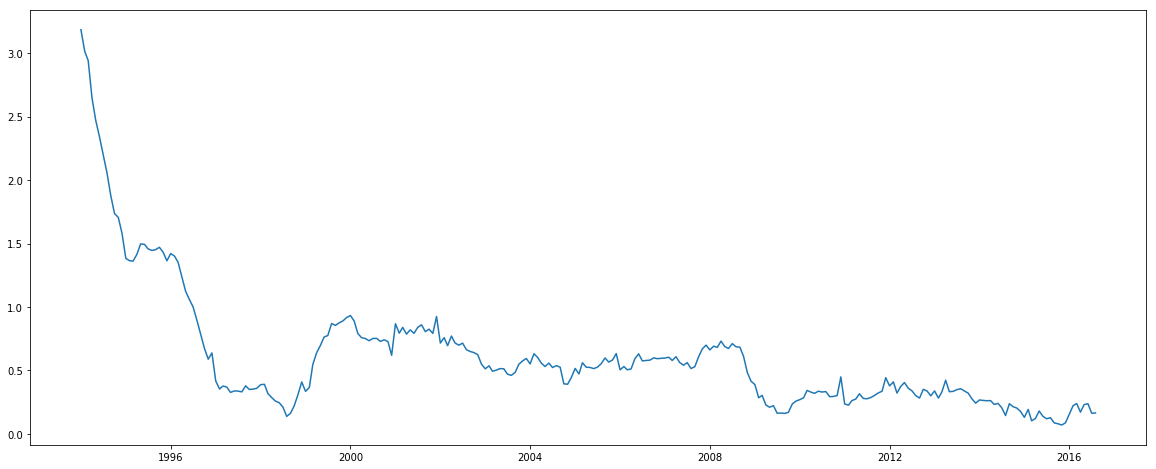

In [14]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
ax.plot(data['month'], data['value_bc_d12'])

plt.show()

Кажется, что удалось избавиться от периодичности в данных. Проведем STL декомпозицию и посчитаем критерий Дики-Фуллера.

Критерий Дики-Фуллера: p=0.008355


<Figure size 1440x576 with 0 Axes>

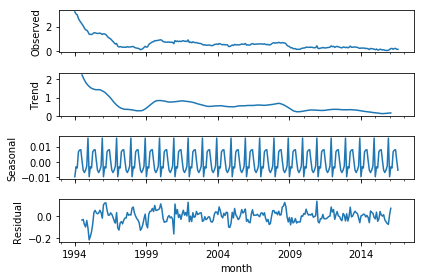

In [15]:
plt.figure(figsize = (20, 8))
sm.tsa.seasonal_decompose(data['value_bc_d12'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['value_bc_d12'][12:])[1])

plt.show()

Из последнего графика видно, что сезонная составляющая осталась, но ее значения очень малы. Критерий Дики-Фуллера позволяет отвергнуть гипотезу о нестационарности ряда. Одноако можно заметить, что у нового ряда есть некоторый тренд, который мы попробуем убрать обычным дифференцированием.

In [16]:
data['value_bc_d12_d1'] = data['value_bc_d12'] - data['value_bc_d12'].shift(1)

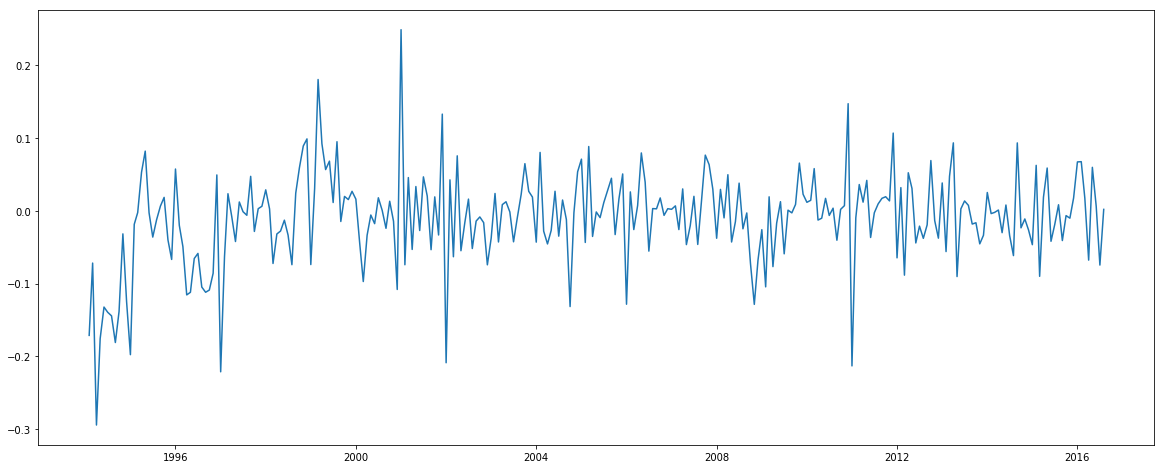

In [17]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
ax.plot(data['month'], data['value_bc_d12_d1'])

plt.show()

Снова посмотрим на критерий и декомпозицию ряда:

Критерий Дики-Фуллера: p=0.021407


<Figure size 1440x576 with 0 Axes>

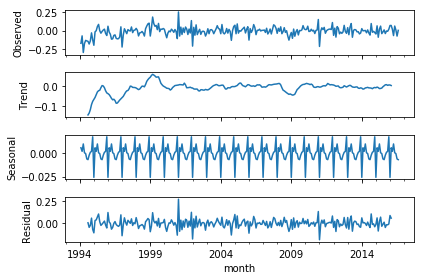

In [18]:
plt.figure(figsize = (20, 8))
sm.tsa.seasonal_decompose(data['value_bc_d12_d1'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['value_bc_d12_d1'][13:])[1])

plt.show()

Критерий стал хуже, хотя все еще позволяет отвергнуть нулевую гипотезу. Можно также заметить, что на некоторых участках ряда тренд остался. Попробуем еще раз применить обычное дифференцирование:

In [19]:
data['value_bc_d12_d1_d1'] = data['value_bc_d12_d1'] - data['value_bc_d12_d1'].shift(1)

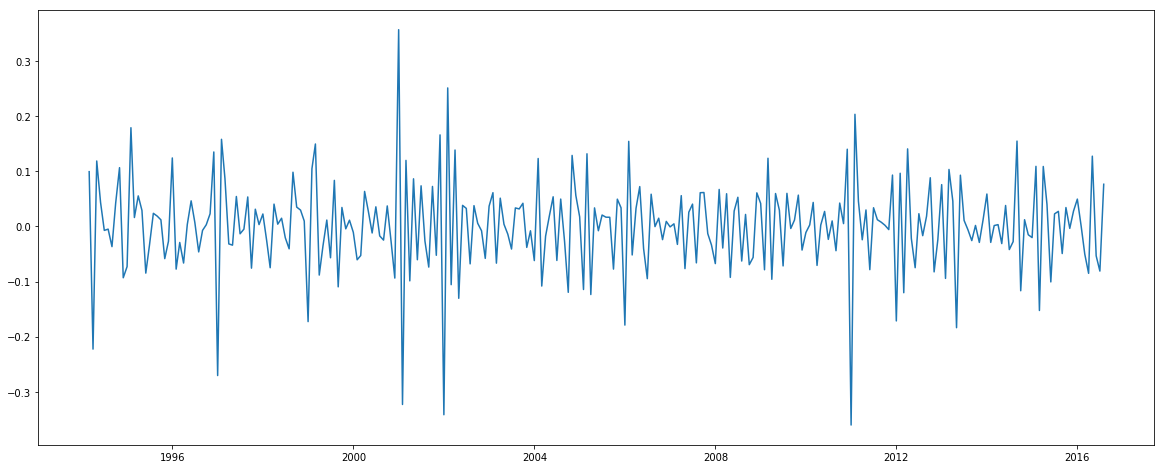

In [20]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
ax.plot(data['month'], data['value_bc_d12_d1_d1'])

plt.show()

Проведем тест на стационарность ряда и сделаем декомпозицию:

In [21]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['value_bc_d12_d1_d1'][14:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1440x576 with 0 Axes>

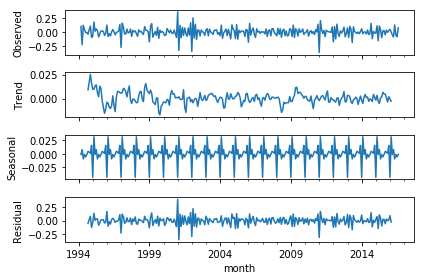

In [22]:
plt.figure(figsize = (20, 8))
sm.tsa.seasonal_decompose(data['value_bc_d12_d1_d1'][14:]).plot()

plt.show()

Из последнего графика можно заметить, что хотя составляющая тренда неидальна, ее амплитуду удалось существенно снизить. 
Плюс значение критерия Дики-Фуллера уверенно отвергает нулевую гипотезу о нестационарности.
Будем считать, что нам удалось получить стационарный ряд. 
Итого нам потребовалось одно сезонное дифференцирование и два обычных.

### 4.Выбор начальных приближений для p, q, P, Q

Для определения параметров построим ACF и PCF преобразованного ряда:

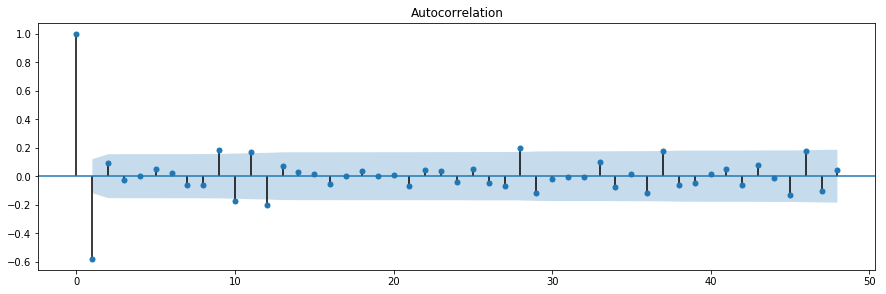

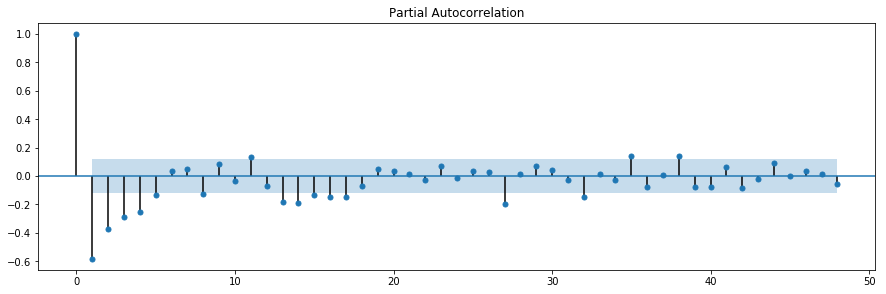

In [23]:
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['value_bc_d12_d1_d1'][14:].values, lags = 48, ax = ax1)
plt.show()

plt.figure(figsize = (15, 10))
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['value_bc_d12_d1_d1'][14:].values, lags = 48, ax = ax2)
plt.show()

Из графика автокорреляционной функции видно, что номер последнего сезонного лага, при котором автокорреляция значима Q = 1. Для несезонного лага q = 1. <br>
Из графика частичной автокорреляционной функции заметим, что сезонных лагов со значимой частичной автокорреляции нет, поэтому P = 0. Для несезонных лагов примерно первые 4 лага имею значимую частичную автокорреляцию, поэтому p = 4. <br>
Итого p = 4, P = 0, q = 1, Q = 1.

### 5.Обучение и сравнение моделей-кандидатов, выбор победителя.

In [24]:
p = range(0, 5)
P = range(0, 2)
q = range(0, 3)
Q = range(0, 3)
d = 2
D = 1

In [25]:
from itertools import product
import warnings

In [26]:
parameters = list(product(p, q, P, Q))
len(parameters)

90

In [27]:
%%time
warnings.filterwarnings('ignore')

best_aic = float('inf')
results = []

for params in parameters:
    try:
        model = sm.tsa.statespace.SARIMAX(data['value_bc'], order = (params[0], d, params[1]), 
                                          seasonal_order = (params[2], D, params[3], 12)).fit(disp = -1)
    except ValueError:
        print('Wrong parameters:', params)
        continue
        
    except LinAlgError:
        print('Wrong parameters LinAlg:', params)
        
    aic = model.aic
    if aic < best_aic:
        best_aic = aic
        best_model = model
        best_params = params
    
    results.append([params, aic])
    
warnings.filterwarnings('default')

Wall time: 2min 48s


C:\Users\29686\Anaconda3\lib\site-packages\IPython\utils\timing.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  return time.clock(),0.0


Сравним модели кандидаты

In [28]:
res_df = pd.DataFrame(results, columns = ['Parameters', 'AIC'])
res_df.sort_values(by = 'AIC', ascending = True).head()

,Parameters,AIC
31,"(1, 2, 0, 1)",-778.802548
33,"(1, 2, 1, 0)",-777.812444
13,"(0, 2, 0, 1)",-777.671959
49,"(2, 2, 0, 1)",-777.613806
15,"(0, 2, 1, 0)",-777.231211


Лучшая модель опережает по AIC на 1 и более ближайших конкурентов.

In [29]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           value_bc   No. Observations:                  284
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 12)   Log Likelihood                 394.401
Date:                            Sun, 06 Jan 2019   AIC                           -778.803
Time:                                    14:39:25   BIC                           -760.810
Sample:                                01-01-1993   HQIC                          -771.578
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3429      0.165      2.074      0.038       0.019       0.667
ma.L1         -1.4041      0.144   

### 6.Анализ остатков лучшей модели

Сделаем обратное преобразование Бокса-Кокса

In [98]:
def boxcox_back(y_tr, lmbda):
    if lmbda == 0:
        y = np.exp(y_tr)
    else:
        y = np.exp(np.log(lmbda*y_tr + 1)/lmbda)
    return y

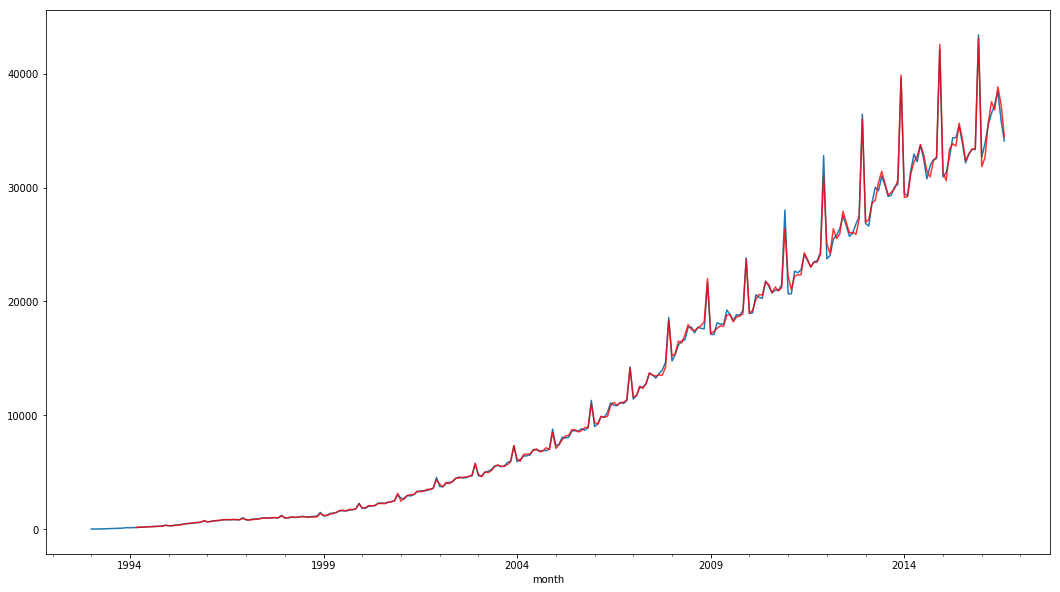

In [99]:
data['model'] = boxcox_back(best_model.fittedvalues, lmbda = 0.1)

fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
data['WAG_C_M'].plot(ax = ax)
data['model'][14:].plot(ax = ax, color = 'r', alpha = 0.8)

Критерий Дики-Фуллера: p=0.000000


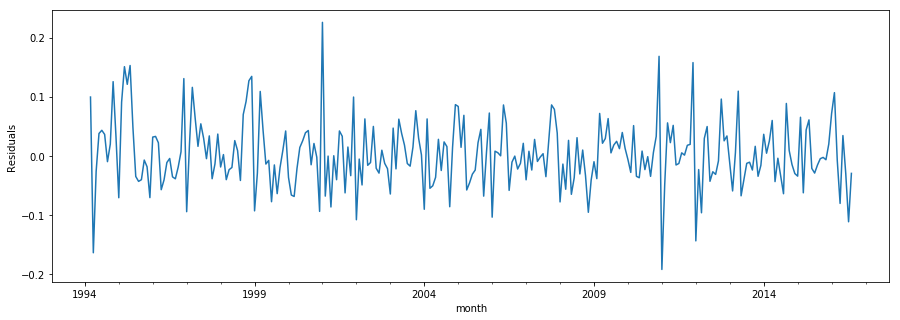

In [30]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(111)
best_model.resid[14:].plot(ax = ax1)
plt.ylabel('Residuals')

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

Согласно значению критерия Дики-Фуллера и графику ряд остатков стационарен. <br>
В идеале среднее остатков должно быть около нуля (как белый шум), проверим это Т-тестом.

In [31]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])

Критерий Стьюдента: p=0.445969


Т-тест не позволяет нам отклонить нулевую гипотезу о равенстве нулю среднего остатков. <br>
Изучим коррелированность остатков.

Text(0,0.5,'ACF')

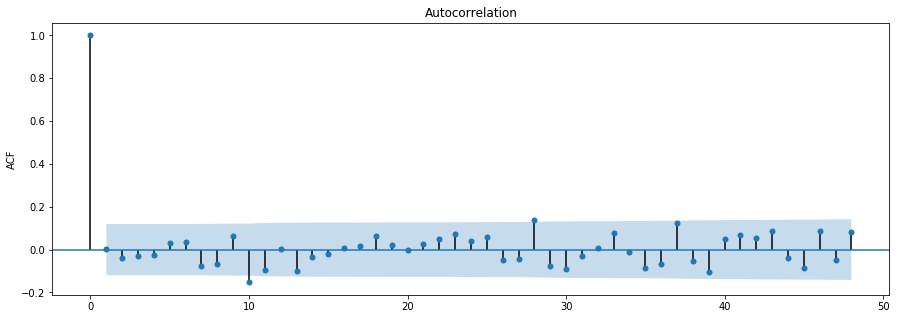

In [32]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values, lags = 48, ax = ax1)
plt.ylabel('ACF')

График показывает, что лагов со значимой корреляцией нет. Плюс критерий Льюнга-Бокса достаточно большой(из summary модели 51.37 p-value оценивается по Хи-квадрат), чтобы отвергнуть гипотезу о наличии коррелированных лагов. <br>
Итого можно заключить, что модель смогла взять из данных главные закономерности. Следовательно модель будем считать хорошей и будем по ней прогнозировать.

### 6.Прогнозирование с помощью финальной модели.

In [93]:
past_salary = pd.DataFrame({'Salary': data['WAG_C_M'].values}, index = data.index)
future_salary = pd.DataFrame(index = pd.date_range(start = '2016-09-01', periods = 36, freq = 'MS'), columns = ['Salary'])
salary = pd.concat([past_salary, future_salary])
salary['predicted'] = boxcox_back(best_model.predict(start = 284, end = 319), lmbda = 0.1)

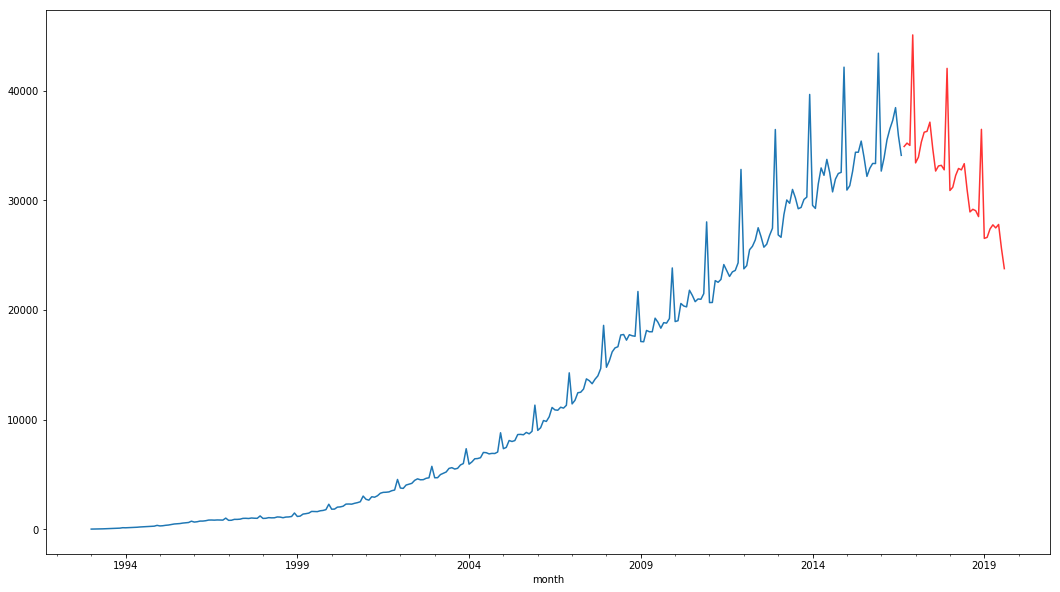

In [95]:
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
data['WAG_C_M'].plot(ax = ax)
salary['predicted'].plot(ax = ax, color = 'r', alpha = 0.8)

Для интереса сравним с реальными данными, ведь они уже известны.

In [125]:
new_data = pd.read_csv('week_1_task_1_new_salary.csv', sep = ',', decimal = ',')
new_data.shape

(35, 2)

In [126]:
new_data.dtypes

month       object
WAG_C_M    float64
dtype: object

In [127]:
new_data['month'] = pd.to_datetime(new_data['month'], format = '%Y-%m-%d')

In [128]:
new_data.index = new_data['month'] 

In [134]:
new_data.columns = ['month', 'new_WAG_C_M']

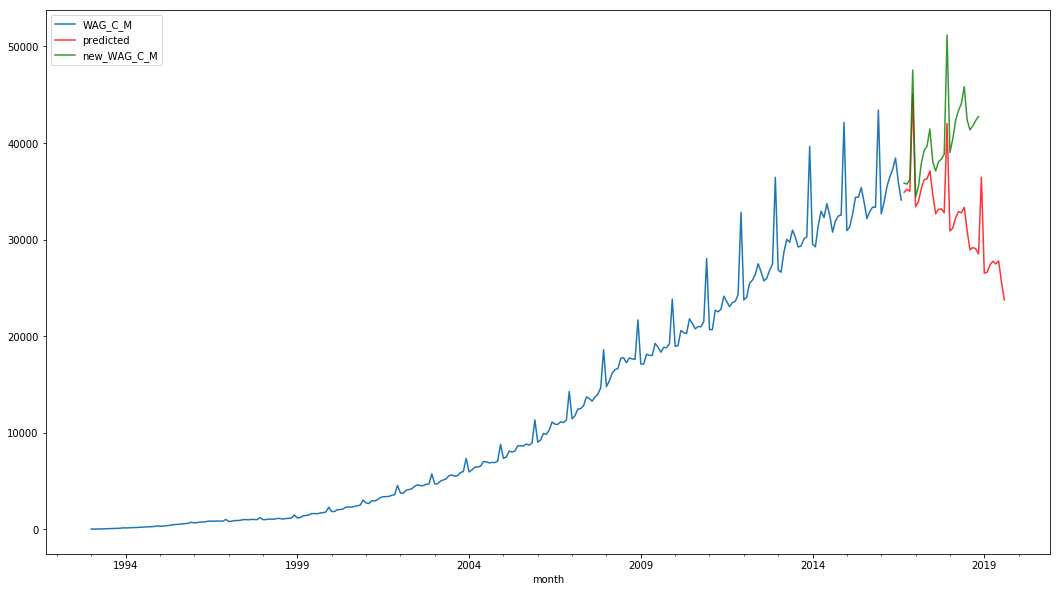

In [136]:
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
data['WAG_C_M'].plot(ax = ax, legend = 'real')
salary['predicted'].plot(ax = ax, color = 'r', alpha = 0.8, legend = 'predicted')
new_data['new_WAG_C_M'][8:].plot(ax = ax, color = 'g', alpha = 0.8, legend = 'new data')